In [1]:
import numpy as np 
import pandas as pd 
import cv2
import scipy
import math
import os, random
from skimage.metrics import structural_similarity
from PIL import Image
from numpy import r_
from scipy import fftpack
from matplotlib import pyplot as plt
%matplotlib inline


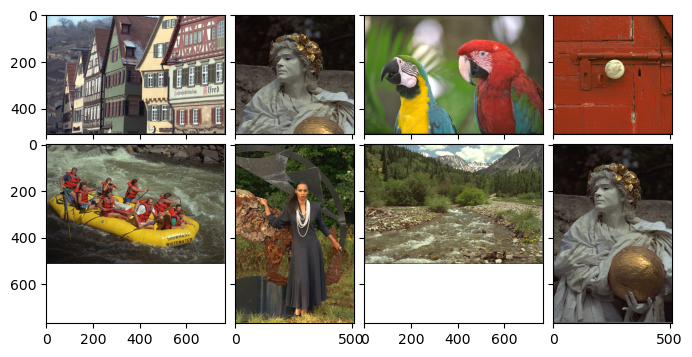

In [2]:
from mpl_toolkits.axes_grid1 import ImageGrid
# PLOT 5 RANDOM IMAGES

# PLOT 8 RANDOM IMAGES

def plot_random_images(data_dir= 'Kodak'):
    imgs = []

    for i in range(8):
        randImagePath = os.path.join(f'{data_dir}', np.random.choice((os.listdir("Kodak"))))
        img = Image.open(randImagePath)
        imgs.append(img)


    fig = plt.figure(figsize=(9., 4.))
    grid = ImageGrid(fig, 111, 
                    nrows_ncols=(2, 4),  # creates 2x2 grid of axes
                    axes_pad=0.1,  # pad between axes in inch.
                    )

    for ax, im in zip(grid, imgs):
        # Iterating over the grid returns the Axes.
        ax.imshow(im)

    plt.show()

plot_random_images()


In [3]:
# UTILITY FUNCTIONS

def load_image(path):
    """ Load image from path. Return a numpy array """
    image = Image.open(path)
    return np.asarray(image) #/ 255

def showImage(img):
    plt.figure()
    plt.imshow(img)
    plt.show()

def PlotGraphs(data, label_x):
  x=data[0]
  y=data[1]
  z=data[2]
  w=data[3]

  plt.scatter(x, y,c='red')
  plt.plot(x, y)
  plt.xlabel(label_x)
  plt.xticks(x) 
  plt.ylabel("CR")
  plt.show()

  plt.scatter(x, z,c='green')
  plt.plot(x, z)
  plt.xlabel(label_x)
  plt.xticks(x) 
  plt.ylabel("PSNR")
  plt.show()

  plt.scatter(x, w,c='blue')
  plt.plot(x, w)
  plt.xlabel(label_x)
  plt.xticks(x) 
  plt.ylabel("SSIM")
  plt.show()

In [4]:
# DCT, IDCT FUNCTIONS
def dct2(a):
    return fftpack.dct(fftpack.dct(a, axis=0, norm='ortho').T, axis=1, norm='ortho').T

def idct2(a):
    return fftpack.idct(fftpack.idct(a, axis=0 , norm='ortho').T, axis=1 , norm='ortho').T

# QUNATIZATION MATRIX FUNCTIONS
def getLuminanceQuantizationMatrix(quality = 50):
    Q10 = np.array([[80,60,50,80,120,200,255,255],
                [55,60,70,95,130,255,255,255],
                [70,65,80,120,200,255,255,255],
                [70,85,110,145,255,255,255,255],
                [90,110,185,255,255,255,255,255],
                [120,175,255,255,255,255,255,255],
                [245,255,255,255,255,255,255,255],
                [255,255,255,255,255,255,255,255]])
    
    Q50 = np.array([[16,11,10,16,24,40,51,61],
                [12,12,14,19,26,58,60,55],
                [14,13,16,24,40,57,69,56],
                [14,17,22,29,51,87,80,62],
                [18,22,37,56,68,109,103,77],
                [24,35,55,64,81,104,113,92],
                [49,64,78,87,103,121,120,101],
                [72,92,95,98,112,100,130,99]])

    Q90 = np.array([[3,2,2,3,5,8,10,12],
                    [2,2,3,4,5,12,12,11],
                    [3,3,3,5,8,11,14,11],
                    [3,3,4,6,10,17,16,12],
                    [4,4,7,11,14,22,21,15],
                    [5,7,11,13,16,12,23,18],
                    [10,13,16,17,21,24,24,21],
                    [14,18,19,20,22,20,20,20]])
    if quality == 10:
        return Q10
    elif quality == 50:
        return Q50
    elif quality == 90:
        return Q90
    else:
        return np.ones((8,8))
    
def getChrominanceQuantizationMatrix(quality = 50):
    Q = np.array([[17, 18, 24, 47, 99, 99, 99, 99],
                  [18, 21, 26, 66, 99, 99, 99, 99],
                  [24, 26, 56, 99, 99, 99, 99, 99],
                  [47, 66, 99, 99, 99, 99, 99, 99],
                  [99, 99, 99, 99, 99, 99, 99, 99],
                  [99, 99, 99, 99, 99, 99, 99, 99],
                  [99, 99, 99, 99, 99, 99, 99, 99],
                  [99, 99, 99, 99, 99, 99, 99, 99]], dtype=int)

    if(quality >= 100):
        return np.ones((8,8))
    if(quality <= 0):
        quality = 1
    if(quality < 50):
        qualityScale = 5000 / quality
    else:
        qualityScale = 200 - quality * 2
    chrominanceQuantTbl = np.array(np.floor((Q * qualityScale + 50) / 100))
    chrominanceQuantTbl[chrominanceQuantTbl == 0] = 1
    chrominanceQuantTbl[chrominanceQuantTbl > 255] = 255
    chrominanceQuantTbl = chrominanceQuantTbl.reshape([8, 8]).astype(int)
    return chrominanceQuantTbl


In [5]:
# MAIN COMPRESSION FUNCTION
def DCT_compression(im, threshold, Lquality, Cquality, verbose=True):    

    imsize = im.shape
    Height = imsize[0]
    Width = imsize[1]
    srcImageMatrix = im
    addedImageMatrix = np.zeros(imsize, dtype=np.uint8)
    for y in range(Height):
        for x in range(Width):
            addedImageMatrix[y][x] = srcImageMatrix[y][x]
            
    yImage,uImage,vImage = Image.fromarray(addedImageMatrix).convert('YCbCr').split()
    yImageMatrix = np.asarray(yImage)
    uImageMatrix = np.asarray(uImage)
    vImageMatrix = np.asarray(vImage)

    LQ = getLuminanceQuantizationMatrix(Lquality)
    CQ = getChrominanceQuantizationMatrix(Cquality)

    yDctMatrix = np.zeros((Height, Width), dtype=np.uint8)
    uDctMatrix = np.zeros((Height, Width), dtype=np.uint8)
    vDctMatrix = np.zeros((Height, Width), dtype=np.uint8)

    yQuantMatrix = np.zeros((Height, Width), dtype=np.uint8)
    uQuantMatrix = np.zeros((Height, Width), dtype=np.uint8)
    vQuantMatrix = np.zeros((Height, Width), dtype=np.uint8)

    Y_dct_thresh = np.zeros((Height, Width), dtype=np.uint8)
    U_dct_thresh = np.zeros((Height, Width), dtype=np.uint8)
    V_dct_thresh = np.zeros((Height, Width), dtype=np.uint8)

    for y in range(0, Height, 8):
        for x in range(0, Width, 8):
            yDctMatrix[y:y + 8, x:x + 8] = dct2(yImageMatrix[y:y + 8, x:x + 8])
            uDctMatrix[y:y + 8, x:x + 8] = dct2(uImageMatrix[y:y + 8, x:x + 8])
            vDctMatrix[y:y + 8, x:x + 8] = dct2(vImageMatrix[y:y + 8, x:x + 8])

            yQuantMatrix[y:y + 8, x:x + 8] = yDctMatrix[y:y + 8, x:x + 8] // LQ
            uQuantMatrix[y:y + 8, x:x + 8] = uDctMatrix[y:y + 8, x:x + 8] // CQ
            vQuantMatrix[y:y + 8, x:x + 8] = vDctMatrix[y:y + 8, x:x + 8] // CQ

    #  Threshold
    Y_dct_thresh = yQuantMatrix * (abs(yQuantMatrix) > (threshold*np.max(yQuantMatrix)))
    percent_nonzeros = np.sum( Y_dct_thresh != 0.0 ) / (imsize[0]*imsize[1]*1.0)
    if verbose:
        print ("Keeping only "+str(round(percent_nonzeros*100.0, 2))+" % of the DCT coefficients of Y Matrix")


    U_dct_thresh = uQuantMatrix * (abs(uQuantMatrix) > (threshold*np.max(uQuantMatrix)))
    percent_nonzeros = np.sum( U_dct_thresh != 0.0 ) / (imsize[0]*imsize[1]*1.0)
    if verbose:
        print ("Keeping only "+str(round(percent_nonzeros*100.0, 2))+" % of the DCT coefficients of U Matrix")


    V_dct_thresh = vQuantMatrix * (abs(vQuantMatrix) > (threshold*np.max(vQuantMatrix)))
    percent_nonzeros = np.sum( V_dct_thresh != 0.0 ) / (imsize[0]*imsize[1]*1.0)
    if verbose:
        print ("Keeping only "+str(round(percent_nonzeros*100.0, 2))+" % of the DCT coefficients of V Matrix")

    Y = Image.fromarray(Y_dct_thresh)
    U = Image.fromarray(U_dct_thresh)
    V = Image.fromarray(V_dct_thresh)
    
    merged_YUV = Image.merge('YCbCr', (Y, U, V)) 
    rgb_img = merged_YUV.convert('RGB') 
    
    return rgb_img

In [6]:
def reverse_compression(im, Lquality, Cquality):
    imsize = im.shape
    Height = imsize[0]
    Width = imsize[1]
    srcImageMatrix = im
    addedImageMatrix = np.zeros(imsize, dtype=np.uint8)
    for y in range(Height):
        for x in range(Width):
            addedImageMatrix[y][x] = srcImageMatrix[y][x]
            
    yImage,uImage,vImage = Image.fromarray(addedImageMatrix).convert('YCbCr').split()
    yImageMatrix = np.asarray(yImage)
    uImageMatrix = np.asarray(uImage)
    vImageMatrix = np.asarray(vImage)

    LQ = getLuminanceQuantizationMatrix(Lquality)
    CQ = getChrominanceQuantizationMatrix(Cquality)

    yReversedQuantMatrix = np.zeros((Height, Width), dtype=np.uint8)
    uReversedQuantMatrix = np.zeros((Height, Width), dtype=np.uint8)
    vReversedQuantMatrix = np.zeros((Height, Width), dtype=np.uint8)

    yIdctMatrix = np.zeros((Height, Width), dtype=np.uint8)
    uIdctMatrix = np.zeros((Height, Width), dtype=np.uint8)
    vIdctMatrix = np.zeros((Height, Width), dtype=np.uint8)

    for y in range(0, Height, 8):
        for x in range(0, Width, 8):
            yReversedQuantMatrix[y:y + 8, x:x + 8] = yImageMatrix[y:y + 8, x:x + 8]*LQ
            uReversedQuantMatrix[y:y + 8, x:x + 8] = uImageMatrix[y:y + 8, x:x + 8]*CQ
            vReversedQuantMatrix[y:y + 8, x:x + 8] = vImageMatrix[y:y + 8, x:x + 8]*CQ

            yIdctMatrix[y:y + 8, x:x + 8] = idct2(yReversedQuantMatrix[y:y + 8, x:x + 8])
            uIdctMatrix[y:y + 8, x:x + 8] = idct2(uReversedQuantMatrix[y:y + 8, x:x + 8])
            vIdctMatrix[y:y + 8, x:x + 8] = idct2(vReversedQuantMatrix[y:y + 8, x:x + 8])

    Y = Image.fromarray(yIdctMatrix)
    U = Image.fromarray(uIdctMatrix)
    V = Image.fromarray(vIdctMatrix)

    merged_YUV = Image.merge('YCbCr', (Y, U, V)) 
    rgb_img = merged_YUV.convert('RGB') 
    
    return rgb_img

In [7]:
# FUNCTIONS TO CALCULATE METRICS

def psnr(original, compressed, verbose=True):
    mse = np.mean( (original - compressed) ** 2 )
    if mse == 0:
        return 100 
    PIXEL_MAX = 255.0
    PSNR = round((20 * math.log10(PIXEL_MAX / math.sqrt(mse))), 3)
    if verbose:
        print("Achieved Peak Signal to Noise Ratio: " + str(PSNR))
    return PSNR

def ssim(original, compressed, verbose=True):
    meanSSIM = structural_similarity(original, compressed, multichannel=True)
    SSIM = round(meanSSIM, 3) 
    if verbose:
        print("Achieved SSIM: " + str(round(meanSSIM, 3)))
    return SSIM

def cr(original_img, compressed_img, verbose=True):
    original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
    compressed_img = cv2.cvtColor(compressed_img, cv2.COLOR_BGR2RGB)

    original_img=cv2.imwrite("original.png", original_img)
    if verbose:
        print("Original File Size: "+str(os.path.getsize("original.png")))
    
    compressed_img=cv2.imwrite("compressed.png", compressed_img)
    if verbose:
        print("Compressed File Size: "+str(os.path.getsize("compressed.png")))
    CR = round(os.path.getsize("original.png")/os.path.getsize("compressed.png"), 3)
    if verbose:
        print("Achieved Compression Ratio: " + str(CR))  
    return CR


Keeping only 57.44 % of the DCT coefficients of Y Matrix
Keeping only 85.28 % of the DCT coefficients of U Matrix
Keeping only 84.37 % of the DCT coefficients of V Matrix
Original File Size: 915652
Compressed File Size: 741926
Achieved Compression Ratio: 1.234
Achieved Peak Signal to Noise Ratio: 28.446
Achieved SSIM: 0.261


/var/folders/8v/b9sqvjrn56sfg2w8vhsmpxdw0000gn/T/ipykernel_40637/966382394.py:14: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  meanSSIM = structural_similarity(original, compressed, multichannel=True)


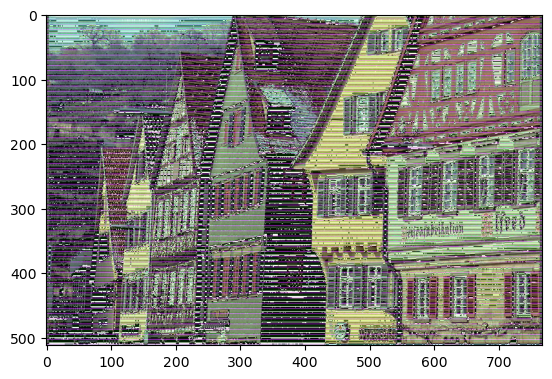

In [8]:
# RUNNING METRICS FOR 1 IMAGE

image = load_image("Kodak/kodim08.png")
# image = load_image("Dataset4K/4k-3840-x-2160-wallpapers-themefoxx (1).jpg")
X_compressed = np.asarray(DCT_compression(image, 0.3, 100, 100))
cr(image, X_compressed)
X_reconstructed = np.asarray(reverse_compression(X_compressed, 100, 100))
psnr(image, X_reconstructed)
ssim(image, X_reconstructed)
plt.imshow(X_reconstructed)


Testing for threshold = 0.0
Keeping only 99.74 % of the DCT coefficients of Y Matrix
Keeping only 100.0 % of the DCT coefficients of U Matrix
Keeping only 100.0 % of the DCT coefficients of V Matrix
Metrics otained: 
Original File Size: 915652
Compressed File Size: 856853
Achieved Compression Ratio: 1.069
Achieved Peak Signal to Noise Ratio: 29.128
Achieved SSIM: 0.404
Testing for threshold = 0.1


/var/folders/8v/b9sqvjrn56sfg2w8vhsmpxdw0000gn/T/ipykernel_40637/966382394.py:14: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  meanSSIM = structural_similarity(original, compressed, multichannel=True)


Keeping only 90.32 % of the DCT coefficients of Y Matrix
Keeping only 100.0 % of the DCT coefficients of U Matrix
Keeping only 100.0 % of the DCT coefficients of V Matrix
Metrics otained: 
Original File Size: 915652
Compressed File Size: 851769
Achieved Compression Ratio: 1.075
Achieved Peak Signal to Noise Ratio: 28.994
Achieved SSIM: 0.384
Testing for threshold = 0.2
Keeping only 74.57 % of the DCT coefficients of Y Matrix
Keeping only 87.51 % of the DCT coefficients of U Matrix
Keeping only 87.54 % of the DCT coefficients of V Matrix
Metrics otained: 
Original File Size: 915652
Compressed File Size: 802137
Achieved Compression Ratio: 1.142
Achieved Peak Signal to Noise Ratio: 28.75
Achieved SSIM: 0.32
Testing for threshold = 0.30000000000000004
Keeping only 57.44 % of the DCT coefficients of Y Matrix
Keeping only 85.28 % of the DCT coefficients of U Matrix
Keeping only 84.37 % of the DCT coefficients of V Matrix
Metrics otained: 
Original File Size: 915652
Compressed File Size: 7419

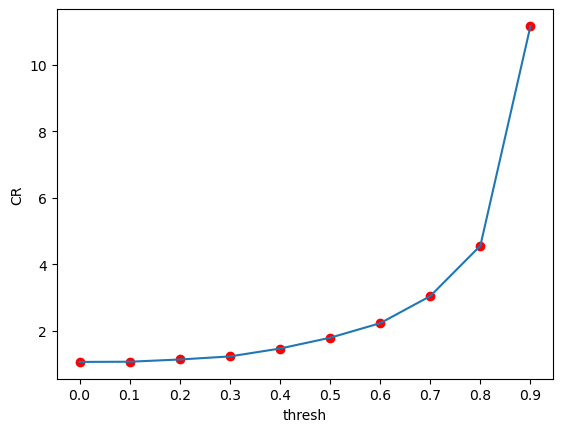

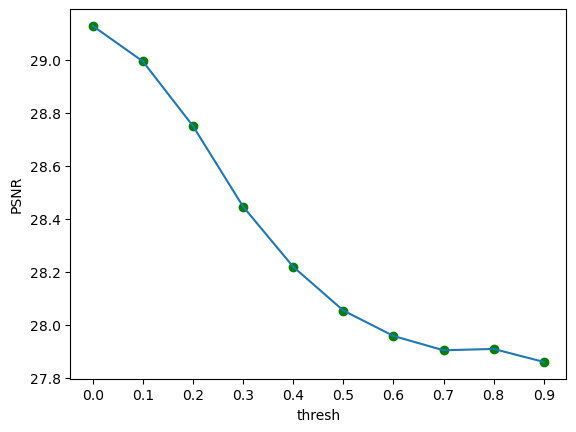

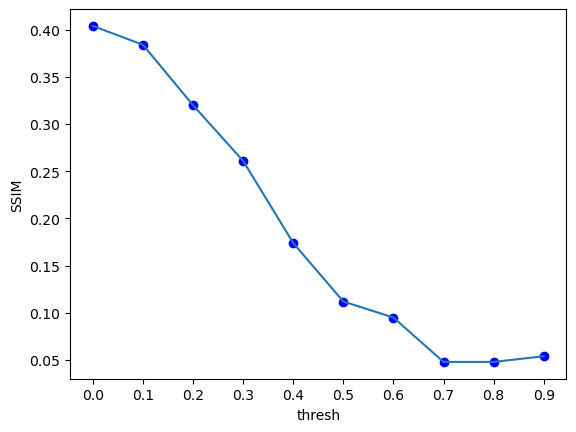

In [9]:
# Plotting graphs for 1 image
image = load_image("Kodak/kodim08.png")
# image = load_image("Dataset4K/4k-3840-x-2160-wallpapers-themefoxx (1).jpg")
thresh = 0.0
threshMax = 0.9
step = 0.1
i=0
noOfMetrics = 3 
eval_data = np.zeros(((int((threshMax-thresh)/step))+1, noOfMetrics + 1), dtype=float)#col1=thresh, col2=cr, col3=psnr, col4=ssim
while thresh<=threshMax:
  eval_data[i][0] = thresh
  print("Testing for threshold = "+str(thresh))
  X_compressed = np.asarray(DCT_compression(image, thresh, 100, 100), dtype=None, order=None )#DCT Transform 
  X_reconstructed = np.asarray(reverse_compression(X_compressed, 100, 100))
  print("Metrics otained: ")
  eval_data[i][1] = cr(image, X_compressed)
  eval_data[i][2] = psnr(image, X_reconstructed)
  eval_data[i][3] = ssim(image, X_reconstructed)
  thresh+=0.1
  i+=1
print("Data obtained after evaluation: ")
print(eval_data)
PlotGraphs(np.ndarray.transpose(eval_data), 'thresh')

In [10]:
import time
from tqdm.notebook import tqdm

def calculate_avg_metrics(data_dir, thresholds = None):
    final_metrics = {}
    
    if thresholds is None:
        thresholds = np.arange(0.2, 1.1, 0.2)
    

    for thresh in thresholds.tolist():
        CR_LIST = []
        PSNR_LIST = []
        SSIM_LIST = []
        TIME_LIST = []
        for file_name in tqdm(os.listdir(data_dir)):
            image_path = os.path.join(data_dir, file_name)
            image = load_image(image_path)

            start_time = time.time()
            X_compressed = np.asarray(DCT_compression(image, thresh, 100, 100, verbose=False), dtype=None, order=None)
            end_time = time.time()

            X_reconstructed = np.asarray(reverse_compression(X_compressed, 100, 100))
            
            TIME_LIST.append(end_time - start_time)
            CR = cr(image, X_compressed, verbose=False)
            PSNR = psnr(image, X_reconstructed, verbose=False)
            SSIM = ssim(image, X_reconstructed, verbose=False)
            
            CR_LIST.append(CR)
            PSNR_LIST.append(PSNR)
            SSIM_LIST.append(SSIM)

        final_metrics[thresh] = {'cr':CR_LIST, 'psnr': PSNR_LIST, 'ssim': SSIM_LIST, 'time': TIME_LIST}
    return final_metrics

In [11]:
kodak_results = calculate_avg_metrics('Kodak')

  0%|          | 0/24 [00:00<?, ?it/s]

/var/folders/8v/b9sqvjrn56sfg2w8vhsmpxdw0000gn/T/ipykernel_40637/966382394.py:14: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  meanSSIM = structural_similarity(original, compressed, multichannel=True)


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

In [13]:
def display_avg_results(results):
    for thresh, values in results.items():
        print(f'For threshold: {thresh: 0.2f}:')
        print(f'mean CR: {np.mean(values["cr"])}')
        print(f'mean PSNR: {np.mean(values["psnr"])}')
        print(f'mean SSIM: {np.mean(values["ssim"])}')
        print(f'avg time: {np.mean(values["time"])}')
        print('\n..........................\n')

In [14]:
display_avg_results(kodak_results)

For threshold:  0.20:
mean CR: 1.1699583333333334
mean PSNR: 28.843333333333334
mean SSIM: 0.26862500000000006
avg time: 0.29697155952453613

..........................

For threshold:  0.40:
mean CR: 1.577625
mean PSNR: 28.367874999999998
mean SSIM: 0.10570833333333333
avg time: 0.2958812713623047

..........................

For threshold:  0.60:
mean CR: 2.8307499999999997
mean PSNR: 27.934875
mean SSIM: 0.04208333333333334
avg time: 0.2942709724108378

..........................

For threshold:  0.80:
mean CR: 8.080541666666667
mean PSNR: 27.944875
mean SSIM: 0.06220833333333334
avg time: 0.29448822140693665

..........................

For threshold:  1.00:
mean CR: 274.37895833333334
mean PSNR: 27.936666666666667
mean SSIM: 0.14445833333333333
avg time: 0.2956701119740804

..........................



In [33]:
import seaborn as sns

def plot_avg_results(results):
    thresh_values = []
    cr_list = []
    psnr_list = []
    ssim_list = []
    time_list = []
        
    for thresh, values in results.items():
        thresh_values.append(thresh)
        cr_list.append(np.mean(values["cr"]))
        psnr_list.append(np.mean(values["psnr"]))
        ssim_list.append(np.mean(values["ssim"]))
        time_list.append(np.mean(values["time"]))

    print(cr_list)
    ax1 = sns.lineplot(x = thresh_values[:-1], y = cr_list[:-1], marker='o')
    ax1.set(xlabel= 'threshold', ylabel='CR', title="Compression Ratio for different thresholds")
    plt.show()

    ax2 = sns.lineplot(x = thresh_values[:-1], y = psnr_list[:-1], marker='o')
    ax2.set(xlabel= 'threshold', ylabel='PSNR', title="PSNR for different thresholds")
    plt.show()

    ax3 = sns.lineplot(x = thresh_values[:-1], y = ssim_list[:-1], marker='o')
    ax3.set(xlabel= 'threshold', ylabel='SSIM', title="SSIM for different thresholds")
    plt.show()

    
    

[1.1699583333333334, 1.577625, 2.8307499999999997, 8.080541666666667, 274.37895833333334]


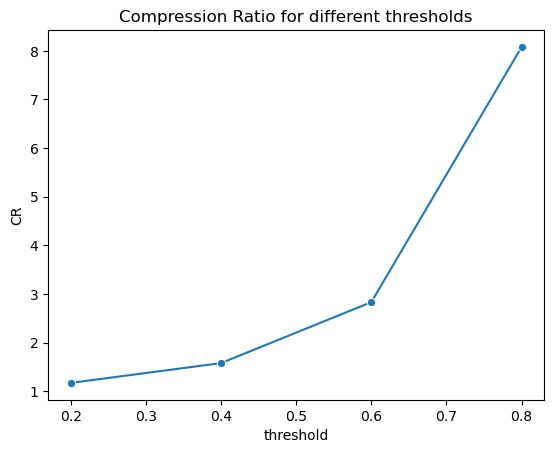

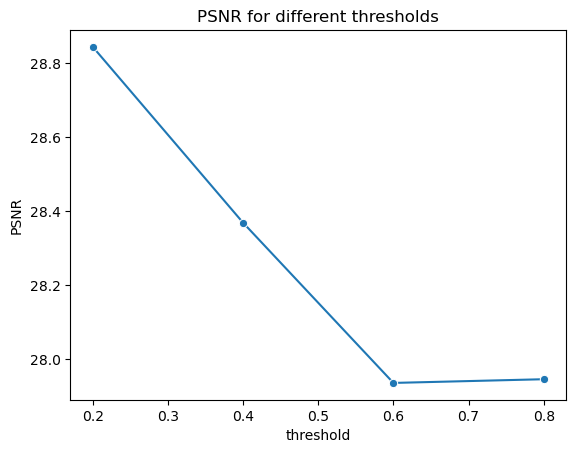

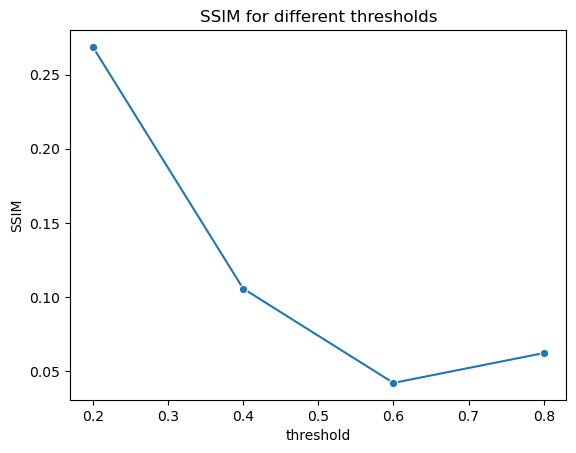

In [34]:
plot_avg_results(kodak_results)

In [ ]:
dataset4k_results =  calculate_avg_metrics('Dataset4k')